In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
tf.logging.set_verbosity(tf.logging.ERROR)  # or any {DEBUG, INFO, WARN, ERROR, FATAL}
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [2]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [3]:
data.test.cls = np.argmax(data.test.labels, axis=1)
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [4]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

# layer_conv1
net = tf.layers.conv2d(inputs=x_image, name='layer_conv1', padding='same',
                       filters=16, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)

# layer_conv2
net = tf.layers.conv2d(inputs=net, name='layer_conv2', padding='same',
                       filters=36, kernel_size=5, activation=tf.nn.relu)
net = tf.layers.max_pooling2d(inputs=net, pool_size=2, strides=2)
print(net)

net = tf.layers.flatten(net)
print(net)

net = tf.layers.dense(inputs=net, name='layer_fc1',
                      units=128, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=net, name='layer_fc_out',
                      units=num_classes, activation=None)
print(logits)

y_pred = tf.nn.softmax(logits=logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=logits)
loss = tf.reduce_mean(cross_entropy)

opt = tf.train.AdamOptimizer(learning_rate=0.01)
optimizer = opt.minimize(loss)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

trainable_var_list = tf.trainable_variables()


Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 7, 7, 36), dtype=float32)
Tensor("flatten/Reshape:0", shape=(?, 1764), dtype=float32)
Tensor("layer_fc_out/BiasAdd:0", shape=(?, 10), dtype=float32)


In [5]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'kernel' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('kernel')

    return variable

In [6]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')
print(weights_conv1)
print(weights_conv2)

weights_fc1 = get_weights_variable(layer_name='layer_fc1')
weights_fc_out = get_weights_variable(layer_name='layer_fc_out')
print(weights_fc1)
print(weights_fc_out)

<tf.Variable 'layer_conv1/kernel:0' shape=(5, 5, 1, 16) dtype=float32_ref>
<tf.Variable 'layer_conv2/kernel:0' shape=(5, 5, 16, 36) dtype=float32_ref>
<tf.Variable 'layer_fc1/kernel:0' shape=(1764, 128) dtype=float32_ref>
<tf.Variable 'layer_fc_out/kernel:0' shape=(128, 10) dtype=float32_ref>


In [7]:
init = tf.global_variables_initializer()
#grad = opt.compute_gradients(loss, weights_fc_out)[0]
grads = tf.gradients(loss, weights_fc_out)[0]
grads_norm = tf.norm(grads)
print(grads)
# arg1: our defined function, arg2: list of tf variables associated with the function
hessian = tf.reduce_sum(tf.hessians(loss, weights_fc_out)[0], axis = 2)
print(hessian)

eigenvalue = tf.linalg.eigvalsh(hessian)
print(eigenvalue)
minimal_ratio = tf.divide(tf.count_nonzero(tf.greater(eigenvalue, 0.)),(eigenvalue.shape[0]*eigenvalue.shape[1]))
print(minimal_ratio)

Tensor("gradients_1/layer_fc_out/MatMul_grad/MatMul_1:0", shape=(128, 10), dtype=float32)
Tensor("Sum:0", shape=(128, 10, 10), dtype=float32)
Tensor("SelfAdjointEigV2:0", shape=(128, 10), dtype=float32)
Tensor("truediv:0", shape=(), dtype=float64)


In [8]:
train_batch_size = 64
n_batch = data.train.num_examples // train_batch_size

loss_list = []
grads_norm_list = []
min_ratio_list = []
sess = tf.Session()
sess.run(init)
for epoch in range(1):
    for batch in range(n_batch):
        batch_xs, batch_ys = data.train.next_batch(train_batch_size)
        _, l, grad_norm,min_ratio = sess.run([optimizer, loss, grads_norm,minimal_ratio], feed_dict={x:batch_xs, y_true:batch_ys})
        loss_list.append(l)
        grads_norm_list.append(grad_norm)
        min_ratio_list.append(min_ratio)
    acc = sess.run(accuracy, feed_dict={x:data.test.images,y_true:data.test.labels})
    print("Epoch " + str(epoch) + " Testing Accuracy: " + str(acc))

Epoch 0 Testing Accuracy: 0.9798


In [11]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = sess.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [12]:
from sklearn.decomposition import PCA
def plot_fc_weights(weights_list):
    # Assume weights in weights_list are TensorFlow ops for 2-dim variables
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w_list = sess.run(weights_list)
    
    pca = PCA(n_components=2)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    
    for w in w_list:
            
        print(w.shape)

        principalComponents = pca.fit_transform(w)

        ax.scatter(principalComponents[:,0], principalComponents[:,1], label=w.shape, alpha=0.5)

    ax.legend()
    plt.show()

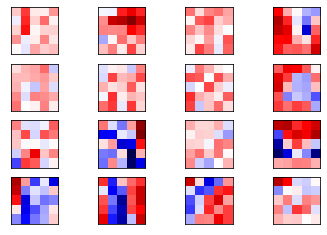

In [13]:
plot_conv_weights(weights=weights_conv1)

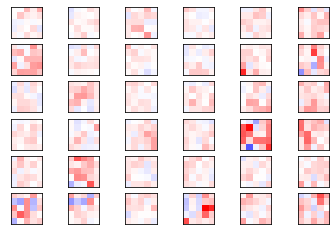

In [14]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

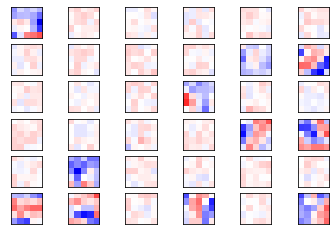

In [15]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

(1764, 128)
(128, 10)


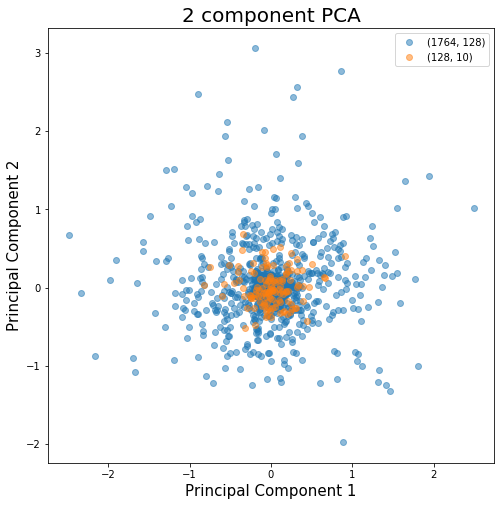

In [16]:
plot_fc_weights(weights_list=[weights_fc1, weights_fc_out])

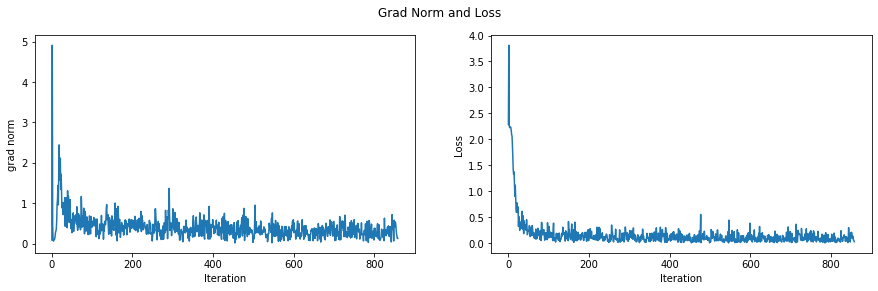

Text(0.5, 1.0, 'Minimal Ratio vs Loss')

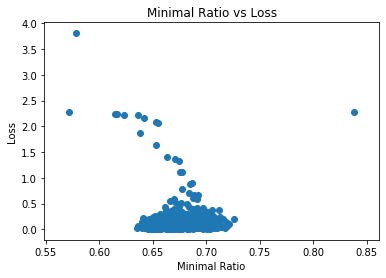

In [17]:
fig,axs = plt.subplots(1,2)
fig.set_figwidth(15)
fig.suptitle('Grad Norm and Loss')
axs[0].plot(grads_norm_list)
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('grad norm')
axs[1].plot(loss_list)
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Loss')
plt.pause(0.1)
plt.scatter(min_ratio_list,loss_list)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss');
plt.title('Minimal Ratio vs Loss')

In [18]:
optimizer = opt.minimize(grads_norm)
grads_loss_list = []
min_ratio_list2 = []
for epoch in range(1):
    for batch in range(n_batch):
        batch_xs, batch_ys = data.train.next_batch(train_batch_size)
        _, l, min_ratio = sess.run([optimizer, loss, minimal_ratio], feed_dict={x:batch_xs, y_true:batch_ys})
        grads_loss_list.append(l)
        min_ratio_list2.append(min_ratio)
    acc = sess.run(accuracy, feed_dict={x:data.test.images,y_true:data.test.labels})
    print("Epoch " + str(epoch) + " Testing Accuracy: " + str(acc))

Epoch 0 Testing Accuracy: 0.9525


Text(0, 0.5, 'Loss')

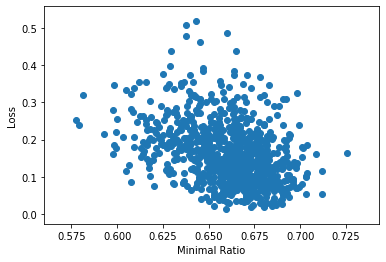

In [19]:
plt.scatter(min_ratio_list2,grads_loss_list)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')